In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import models
from torchvision import datasets
from torchvision import transforms
from torchmetrics.classification import MulticlassAccuracy
import numpy as np
from collections import OrderedDict
import matplotlib.pyplot as plt
import datetime

Fontconfig warning: ignoring UTF-8: not a valid region tag


In [2]:
no_epochs = 50
learning_rate = 0.0001
batch_size = 128

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

acc_function = MulticlassAccuracy(num_classes=102, average='micro').to(device)
loss_fn = nn.CrossEntropyLoss()

SEED = 42
np.random.seed(SEED)
generator = torch.Generator().manual_seed(SEED)

PATH = './model.pth'

cuda:0


In [3]:
# Data Augmentation
train_transforms = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Assuming you want to keep the default transformations for testing/validation:
default_transforms = transforms.Compose([
    models.VGG16_BN_Weights.IMAGENET1K_V1.transforms()
])

flowers_train = datasets.Flowers102(root='./data', split='train', download=True, transform=train_transforms)
flowers_test = datasets.Flowers102(root='./data', split='test', download=True, transform=default_transforms)
flowers_val = datasets.Flowers102(root='./data', split='val', download=True, transform=default_transforms)


In [4]:
def get_data_loader(batch_size):
    train_loader = torch.utils.data.DataLoader(flowers_train, batch_size=batch_size, shuffle=True, generator=generator)
    test_loader = torch.utils.data.DataLoader(flowers_test, batch_size=batch_size, shuffle=True, generator=generator)
    val_loader = torch.utils.data.DataLoader(flowers_val, batch_size=batch_size, shuffle=True, generator=generator)
    return train_loader, test_loader, val_loader

In [5]:
# Early stopping based on accuracy
class AccuracyEarlyStopper:
    def __init__(self, patience=5, min_delta=0.01):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.max_validation_accuracy = 0

    def early_stop(self, validation_accuracy):
        if validation_accuracy > (self.max_validation_accuracy + self.min_delta):
            self.max_validation_accuracy = validation_accuracy
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [6]:
def train(model, optimizer, dataloader, loss_fn=loss_fn):
    running_loss_value = 0
    for images, labels in dataloader:
        optimizer.zero_grad()
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        running_loss_value += loss.item()
        loss.backward()
        optimizer.step()
    return running_loss_value / len(dataloader)

def test_eval(model, dataloader, loss_fn=loss_fn):
    running_loss_value = 0
    running_acc_value = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            acc = acc_function(outputs, labels)
            running_loss_value += loss.item()
            running_acc_value += acc.item()
    running_acc_value /= len(dataloader)
    running_loss_value /= len(dataloader)
    return running_acc_value*100, running_loss_value

def train_eval_test(model, train_dataloader, val_dataloader, test_dataloader, no_epochs=10):
    es = AccuracyEarlyStopper()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    train_loss_arr, train_acc_arr, eval_loss_arr, eval_acc_arr, train_time = [], [], [], [], []
    for i in range(no_epochs):
        start = datetime.datetime.now()
        train_loss = train(model, optimizer, train_dataloader)
        end = datetime.datetime.now()
        eval_acc, eval_loss = test_eval(model, val_dataloader)
        time_taken = (end-start).total_seconds()
        print(f'Epoch {i+1} Train Loss: {train_loss:>8f}, Eval Accuracy: {eval_acc:>0.2f}%, Eval Loss: {eval_loss:>8f}, Train Time: {time_taken:>0.2f}s')
        train_loss_arr.append(train_loss)
        eval_loss_arr.append(eval_loss)
        eval_acc_arr.append(eval_acc)
        train_time.append(time_taken)
        if es.early_stop(eval_acc):
            print('Early stopping activated')
            break
    test_acc, test_loss = test_eval(model, test_dataloader)
    print(f"Test Accuracy: {test_acc}, Test Loss: {test_loss}")
    return train_loss_arr, train_acc_arr, eval_loss_arr, eval_acc_arr, test_acc, test_loss, train_time

In [7]:
class ModifiedResNet(nn.Module):
    def __init__(self, num_classes=102):
        super(ModifiedResNet, self).__init__()
        self.resnet = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)
                        
        new_last_layer_1 = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), bias=False)),
            ('bn1', nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
            ('relu1', nn.ReLU(inplace=True)),
            ('conv2', nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1,1), bias=False)),
            ('bn2', nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
            ('conv3', nn.Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)),
            ('bn3', nn.BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
            ('relu2', nn.ReLU(inplace=True)),
            ('downsample', nn.Sequential(OrderedDict([
                ('0', nn.Conv2d(2048, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)),
                ('1', nn.BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))
            ])))
        ]))
        
        new_last_layer_2 = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)),
            ('bn1', nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
            ('conv2', nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)),
            ('bn2', nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
            ('conv3', nn.Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)),
            ('bn3', nn.BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
            ('relu', nn.ReLU(inplace=True))
        ]))
        
        new_last_layer_3 = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)),
            ('bn1', nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
            ('conv2', nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)),
            ('bn2', nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
            ('conv3', nn.Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)),
            ('bn3', nn.BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
            ('relu', nn.ReLU(inplace=True))
        ]))
        
        new_last_layer = nn.Sequential(OrderedDict([
            ('1', new_last_layer_1),
            ('2', new_last_layer_2),
            ('3', new_last_layer_3)
        ]))
        self.resnet.layer4 = new_last_layer
        self.resnet.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.resnet.fc = nn.Linear(2048, num_classes, bias=True)
        
    def forward(self, x):
        return self.resnet(x)
    

In [8]:
train_data_loader, test_data_loader, val_data_loader = get_data_loader(batch_size)

In [9]:
modified_model = ModifiedResNet().to(device)
modified_train_acc, modified_train_loss, modified_eval_acc, modified_eval_loss, modified_test_acc, modified_test_loss, modified_train_time = train_eval_test(
    modified_model, 
    train_data_loader, 
    val_data_loader, 
    test_data_loader,
    no_epochs=no_epochs
)

del modified_model

Epoch 1 Train Loss: 4.370101, Eval Accuracy: 31.16%, Eval Loss: 3.684789, Train Time: 32.95s
Epoch 2 Train Loss: 3.462003, Eval Accuracy: 46.08%, Eval Loss: 2.992656, Train Time: 9.67s
Epoch 3 Train Loss: 2.843658, Eval Accuracy: 57.75%, Eval Loss: 2.474466, Train Time: 9.94s
Epoch 4 Train Loss: 2.327082, Eval Accuracy: 66.18%, Eval Loss: 2.047753, Train Time: 9.79s
Epoch 5 Train Loss: 1.964698, Eval Accuracy: 74.04%, Eval Loss: 1.735801, Train Time: 9.41s
Epoch 6 Train Loss: 1.640428, Eval Accuracy: 79.31%, Eval Loss: 1.461535, Train Time: 9.39s
Epoch 7 Train Loss: 1.396344, Eval Accuracy: 83.21%, Eval Loss: 1.273286, Train Time: 9.81s
Epoch 8 Train Loss: 1.169309, Eval Accuracy: 83.82%, Eval Loss: 1.119362, Train Time: 10.23s
Epoch 9 Train Loss: 0.983943, Eval Accuracy: 84.62%, Eval Loss: 1.019340, Train Time: 9.34s
Epoch 10 Train Loss: 0.826325, Eval Accuracy: 85.07%, Eval Loss: 0.876586, Train Time: 9.38s
Epoch 11 Train Loss: 0.711376, Eval Accuracy: 87.85%, Eval Loss: 0.811085, Tr

In [10]:
base_model = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)
base_model.fc = nn.Linear(512, 102)
base_model = base_model.to(device)
base_train_acc, base_train_loss, base_eval_acc, base_eval_loss, base_test_acc, base_test_loss, base_train_time = train_eval_test(
    base_model, 
    train_data_loader, 
    val_data_loader, 
    test_data_loader,
    no_epochs=no_epochs
)

del base_model

Epoch 1 Train Loss: 4.576360, Eval Accuracy: 15.50%, Eval Loss: 4.004943, Train Time: 9.66s
Epoch 2 Train Loss: 3.610128, Eval Accuracy: 44.78%, Eval Loss: 3.218554, Train Time: 9.23s
Epoch 3 Train Loss: 2.863282, Eval Accuracy: 61.95%, Eval Loss: 2.605871, Train Time: 9.23s
Epoch 4 Train Loss: 2.264600, Eval Accuracy: 72.04%, Eval Loss: 2.117710, Train Time: 10.76s
Epoch 5 Train Loss: 1.819673, Eval Accuracy: 79.11%, Eval Loss: 1.738529, Train Time: 9.36s
Epoch 6 Train Loss: 1.457412, Eval Accuracy: 82.84%, Eval Loss: 1.438333, Train Time: 9.16s
Epoch 7 Train Loss: 1.169566, Eval Accuracy: 85.77%, Eval Loss: 1.193888, Train Time: 9.18s
Epoch 8 Train Loss: 0.899018, Eval Accuracy: 87.86%, Eval Loss: 1.011892, Train Time: 9.30s
Epoch 9 Train Loss: 0.760726, Eval Accuracy: 87.74%, Eval Loss: 0.891522, Train Time: 9.28s
Epoch 10 Train Loss: 0.614413, Eval Accuracy: 89.50%, Eval Loss: 0.773017, Train Time: 9.85s
Epoch 11 Train Loss: 0.505763, Eval Accuracy: 90.99%, Eval Loss: 0.675672, Tra

In [11]:
class ResNet34WithSE(nn.Module):
    def __init__(self, num_classes):
        super(ResNet34WithSE, self).__init__()
        self.resnet = torchvision.models.resnet34(weights=models.ResNet34_Weights.DEFAULT)

        self.resnet.layer1.add_module('SEBlock', torchvision.ops.SqueezeExcitation(64, 16))
        self.resnet.layer2.add_module('SEBlock', torchvision.ops.SqueezeExcitation(128, 16))
        self.resnet.layer3.add_module('SEBlock', torchvision.ops.SqueezeExcitation(256, 16))
        self.resnet.layer4.add_module('SEBlock', torchvision.ops.SqueezeExcitation(512, 16))
        self.resnet.fc = nn.Linear(512, num_classes)

        
    def forward(self, x):
        x = self.resnet(x)
        return x

# Initialize the ResNet-34 model with SE blocks
num_classes = 102  # Replace with the number of classes in your dataset
SE_model = ResNet34WithSE(num_classes)

SE_model = SE_model.to(device=device)

In [12]:
SE_train_acc, SE_train_loss, SE_eval_acc, SE_eval_loss, SE_test_acc, SE_test_loss, SE_train_time = train_eval_test(
    SE_model, 
    train_data_loader, 
    val_data_loader, 
    test_data_loader,
    no_epochs=no_epochs
)

del SE_model

Epoch 1 Train Loss: 4.546335, Eval Accuracy: 17.46%, Eval Loss: 4.232080, Train Time: 9.69s
Epoch 2 Train Loss: 4.049612, Eval Accuracy: 38.91%, Eval Loss: 3.806367, Train Time: 9.41s
Epoch 3 Train Loss: 3.604606, Eval Accuracy: 54.69%, Eval Loss: 3.410523, Train Time: 9.24s
Epoch 4 Train Loss: 3.185153, Eval Accuracy: 62.56%, Eval Loss: 3.038314, Train Time: 9.33s
Epoch 5 Train Loss: 2.842834, Eval Accuracy: 68.54%, Eval Loss: 2.690348, Train Time: 10.12s
Epoch 6 Train Loss: 2.470093, Eval Accuracy: 73.23%, Eval Loss: 2.360730, Train Time: 9.23s
Epoch 7 Train Loss: 2.156985, Eval Accuracy: 77.48%, Eval Loss: 2.070572, Train Time: 9.24s
Epoch 8 Train Loss: 1.840901, Eval Accuracy: 81.97%, Eval Loss: 1.807386, Train Time: 9.31s
Epoch 9 Train Loss: 1.554744, Eval Accuracy: 84.10%, Eval Loss: 1.550611, Train Time: 11.06s
Epoch 10 Train Loss: 1.306842, Eval Accuracy: 85.98%, Eval Loss: 1.336305, Train Time: 9.21s
Epoch 11 Train Loss: 1.063595, Eval Accuracy: 87.46%, Eval Loss: 1.137800, Tr

In [13]:
eval_acc = [np.mean(base_eval_acc), np.mean(modified_eval_acc), np.mean(SE_eval_acc)]
test_acc = [base_test_acc, modified_test_acc, SE_test_acc]
time_taken = [np.mean(base_train_time), np.mean(modified_train_time), np.mean(SE_train_time)]
names = ['base', 'modified', 'SE']
colours = ['tab:red', 'tab:blue', 'tab:green']

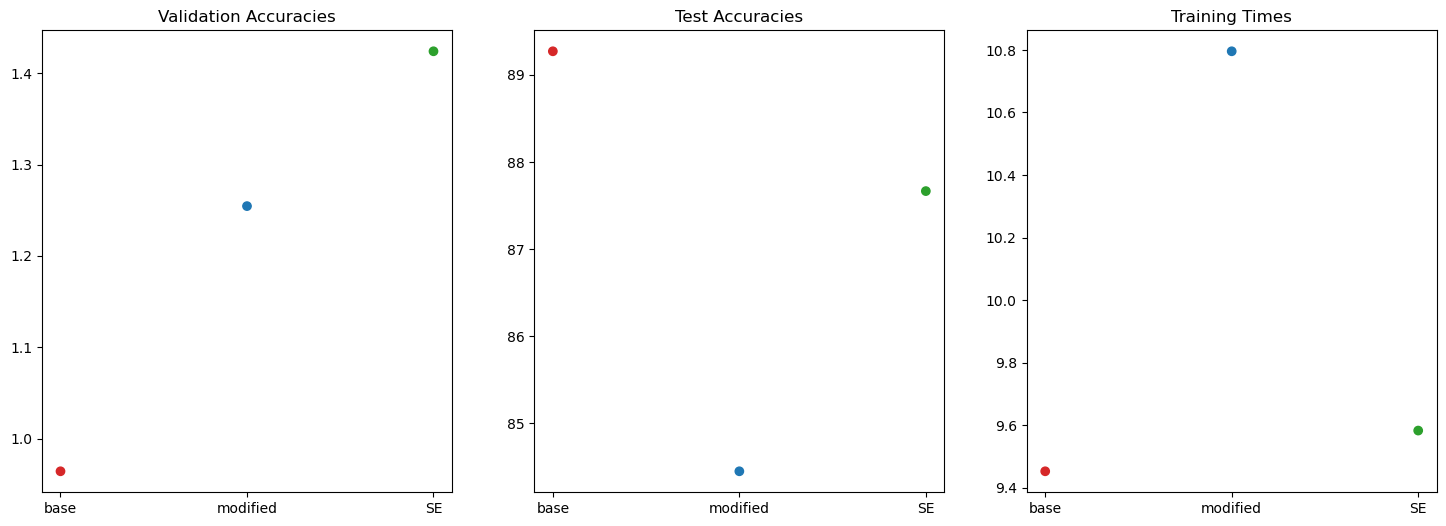

In [14]:
plt.figure(figsize=(18, 6))
plt.subplot(131)
plt.title('Validation Accuracies')
plt.scatter(names, eval_acc, color=colours)
plt.subplot(132)
plt.title('Test Accuracies')
plt.scatter(names, test_acc, color=colours)
plt.subplot(133)
plt.title('Training Times')
plt.scatter(names, time_taken, color=colours)
plt.show()